In [1]:
import numpy as np
import matplotlib.pyplot as plt

import starspot as ss

import numpyro
numpyro.set_host_device_count(2)

from tqdm import tqdm

import jax
import jax.numpy as jnp

import jaxopt, optax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from tinygp import kernels, GaussianProcess

jax.config.update("jax_enable_x64", True)


/Users/benjaminpope/opt/anaconda3/envs/starspot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Generate some data
time = np.linspace(0, 100, 1000)
period = 10
w = 2*np.pi/period
flux = np.sin(w*time) + np.random.randn(len(time))*1e-2 + \
    np.random.randn(len(time))*.01
flux_err = np.ones_like(flux)*.01

rotate = ss.RotationModel(time, flux, flux_err)


In [3]:

# Calculate the Lomb Scargle periodogram period (highest peak in the periodogram).
lomb_scargle_period = rotate.ls_rotation()


In [4]:

# Calculate the autocorrelation function (ACF) period (highest peak in the ACF).
# This is for evenly sampled data only -- time between observations is 'interval'.
acf_period = rotate.acf_rotation(interval=np.diff(time)[0])
print(acf_period)

10.01001001001001


In [5]:

# Calculate the phase dispersion minimization period (period of lowest dispersion).
period_grid = np.linspace(5, 20, 1000)
pdm_period = rotate.pdm_rotation(period_grid)

print(lomb_scargle_period, acf_period, pdm_period)
# >> 9.99892010582963 10.011001100110011 10.0


 27%|██▋       | 268/1000 [00:00<00:00, 1372.77it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1376.71it/s]


10.000720059044841 10.01001001001001 (10.015015015015015, 0.33368317344473725)


So! The ACF, PDM, and LS periods work fine! Just the GP bit to worry about.

In [6]:

# Calculate a Gaussian process rotation period
# gp_period = rotate.gp_rotation()
# this no longer works because Theano is broken!

How can we re-implement the stellar rotational kernel in Jax? Let's use tinygp and see if we can fit to a sine wave, and fit to real GP draws!

In [7]:
t = jnp.array(rotate.time, dtype=float)
t_fine = jnp.linspace(t.min(), t.max(), np.max([1000, len(t)*10]))
# Median of data must be zero
y = jnp.array(rotate.flux, dtype=float) - jnp.median(rotate.flux)
yerr = jnp.array(rotate.flux_err, dtype=float)


init_period = rotate.ls_rotation()


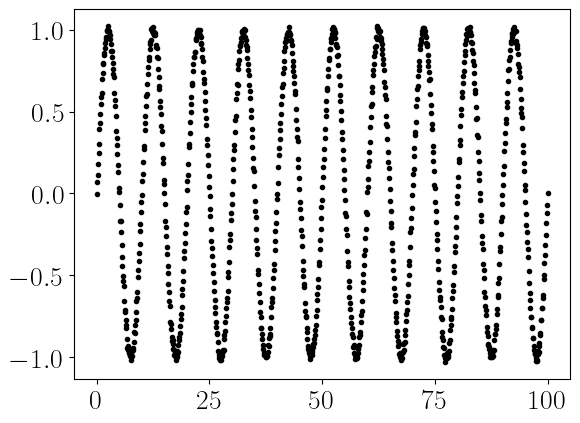

In [8]:
plt.plot(t, y, '.k', label='y(t)')

Now the following code is going to want to live in `starspot.py` and replace the existing GP implementation using `tinygp`. We will closely follow the [tinygp docs](https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html).

In [9]:
def build_gp(params):

    sigma, period, Q0, dQ, f = (jnp.exp(params['log_sigma']), jnp.exp(params['log_period']), 
                                jnp.exp(params['log_Q0']), jnp.exp(params['log_deltaQ']), jnp.exp(params['log_f']))

    amp = sigma**2 / (1 + f)

    # One term with a period of period
    Q1 = 0.5 + Q0 + dQ
    w1 = 4 * jnp.pi * Q1 / (period * jnp.sqrt(4 * Q1**2 - 1))
    S1 = amp / (w1 * Q1)

    # Another term at half the period
    Q2 = 0.5 + Q0
    w2 = 8 * jnp.pi * Q2 / (period * jnp.sqrt(4 * Q2**2 - 1))
    S2 = f * amp / (w2 * Q2)

    # SHOTerm(S0=S1, w0=w1, Q=Q1), SHOTerm(S0=S2, w0=w2, Q=Q2)
    kernel = kernels.quasisep.SHO(sigma=S1,omega=w1, quality=Q1) + kernels.quasisep.SHO(sigma=S2,omega=w2,quality=Q2)
    
    return GaussianProcess(
        kernel,
        t,
        diag=yerr**2 + jnp.exp(params["log_jitter"]),
        mean=params["mean"],
    )

@jax.jit
def loss(params):
    gp = build_gp(params)
    return -gp.log_probability(y)

First do optimization. The suggested `jaxopt` version quickly runs out of bounds - yikes! 

In [11]:
# initial guess for the parameters
params = {
    "mean": 0.0, # mean flux
    "log_jitter": 2*jnp.log(jnp.min(yerr)), # jitter
    "log_sigma": jnp.log(jnp.var(y)), # variance
    "log_period": jnp.log(init_period), # 2*pi/period
    "log_Q0": 1., # quality factor
    "log_deltaQ": 2.0, # 2.0
    "log_f": 0.5, # mixture parameter
}
print(f"Initial negative log likelihood: {loss(params)}")

print("Initial Optimization")
solver = jaxopt.ScipyMinimize(fun=loss)
soln = solver.run(jax.tree_util.tree_map(jnp.asarray, params))
print(f"Final negative log likelihood: {soln.state.fun_val}")
params_str = ', '.join([f"{key.strip('log_')}: {jnp.exp(val):.2f}" for key, val in params.items()])
print(f"Final parameters: {{{params_str}}}")   


Initial negative log likelihood: 1767.4530879046351
Initial Optimization
Final negative log likelihood: -2783.486066685661
Final parameters: {mean: 1.00, jitter: 0.00, sigma: 0.50, period: 10.00, Q0: 2.72, deltaQ: 7.39, f: 1.65}


Out of bounds, this sucks. Let's just do a stochastic gradient descent instead.

(Array(1767.4530879, dtype=float64), {'log_Q0': Array(3481.1422325, dtype=float64, weak_type=True), 'log_deltaQ': Array(3288.60765094, dtype=float64, weak_type=True), 'log_f': Array(3537.87538633, dtype=float64, weak_type=True), 'log_jitter': Array(-21.13155494, dtype=float64), 'log_period': Array(-11609.31436856, dtype=float64), 'log_sigma': Array(-17502.2332228, dtype=float64), 'mean': Array(222.50752923, dtype=float64, weak_type=True)})


100%|██████████| 101/101 [00:03<00:00, 29.61it/s]


Text(0.5, 0, 'step number')

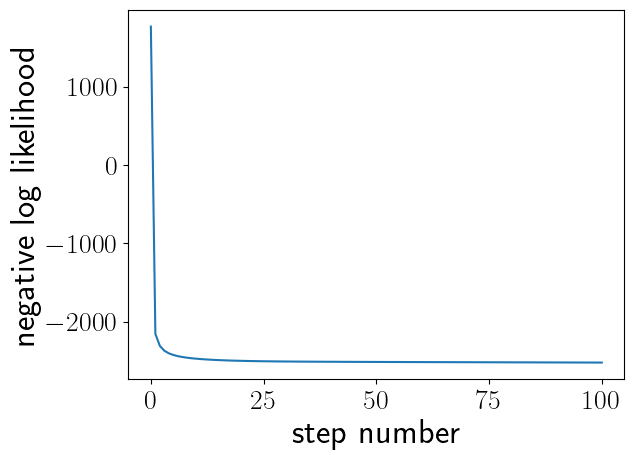

In [12]:
tx = optax.sgd(learning_rate=3e-5)

params = {
    "mean": 0.0, # mean flux
    "log_jitter": 2*jnp.log(jnp.min(yerr)), # jitter
    "log_sigma": jnp.log(jnp.var(y)), # variance
    "log_period": jnp.log(init_period), # 2*pi/period
    "log_Q0": 1., # quality factor
    "log_deltaQ": 2.0, # 2.0
    "log_f": 0.5 # mixture parameter
}

# print(f"Initial negative log likelihood: {loss(params)}")

print("Initial Optimization")

opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))
# print(loss_grad_fn(params))

losses = []
for i in tqdm(range(101)):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
plt.xlabel("step number")

print(f"Final negative log likelihood: {soln.state.fun_val}")
params_str = ', '.join([f"{key.strip('log_')}: {jnp.exp(val):.2f}" for key, val in params.items()])
print(f"Final parameters: {{{params_str}}}")   


Much better curve but not sure about the parameters.

In [ ]:
pred = model.apply(params, t, yerr, y, true_t)[1]

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred, label="max likelihood model")
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")


Let's just do the numpyro inference with HMC.

In [45]:
def numpyro_model(t, yerr, y=None):
    # The mean flux of the time series
    mean = numpyro.sample("mean", dist.Normal(0.0, 10.0))

    # A jitter term describing excess white noise
    log_jitter = numpyro.sample("log_jitter", dist.Normal(2*jnp.log(jnp.min(yerr)), 5.0))

    # The parameters of the RotationTerm kernel
    log_sigma = numpyro.sample("log_sigma", dist.Normal(jnp.log(jnp.var(y)), 5.0))
    log_period = numpyro.sample("log_period", dist.Normal(jnp.log(init_period), 5.0))
    log_Q0 = numpyro.sample("log_Q0", dist.Normal(1.0, 10.0))
    log_deltaQ = numpyro.sample("log_deltaQ", dist.Normal(2.0, 10.0))
    mix = numpyro.sample("mix", dist.Uniform(0, 1.0))

    # Track the period as a deterministic
    period = jnp.exp(log_period)
    params = {'log_sigma': log_sigma, 'log_period': log_period, 'log_Q0': log_Q0,
                'log_deltaQ': log_deltaQ, 'log_f': mix, 
                'mean': mean, 'log_jitter': log_jitter}
    # sigma, period, Q0, dQ, f = jnp.exp(params['log_sigma'], params['log_period'], 
    #                            params['log_Q0'], params['log_deltaQ'], params['log_f'])

    gp = build_gp(params)
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t_fine).gp.loc)


In [26]:
nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, t, yerr, y=y)
samples = mcmc.get_samples()


Running chain 1: 100%|██████████| 1000/1000 [19:34<00:00,  1.17s/it]


In [27]:
from chainconsumer import ChainConsumer


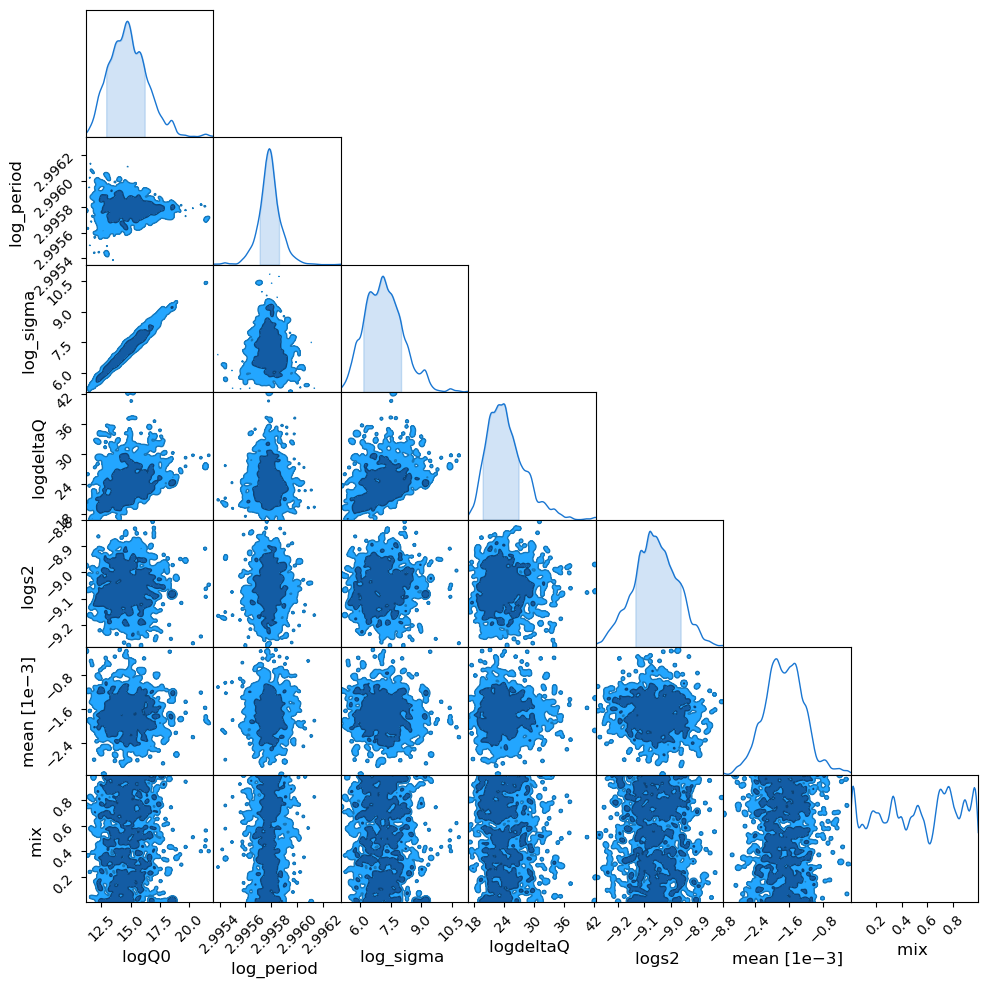

In [31]:
c= ChainConsumer()
c.add_chain([samples[key] for key in ['logQ0', 'log_period', 'log_sigma', 'logdeltaQ', 'logs2', 'mean', 'mix']], parameters=['logQ0', 'log_period', 'log_sigma', 'logdeltaQ', 'logs2', 'mean', 'mix'], name = 'HMC only')
c.plotter.plot(truth=true_params)
plt.show()


It actually didn't do super well on the perfect sinusoid. How does it handle a GP - where the model is misspecified?

In [53]:
gp = build_gp(true_params)

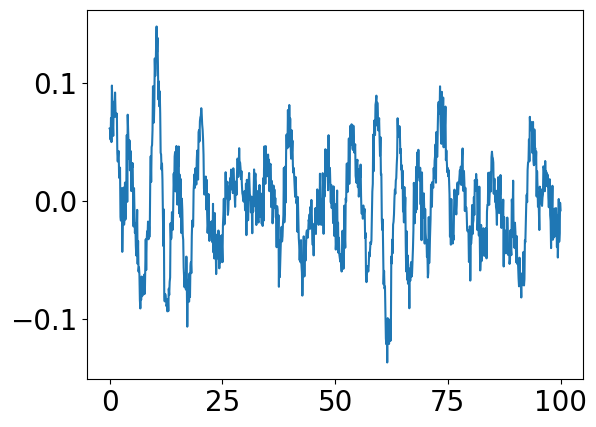

In [55]:
test = gp.sample(jax.random.PRNGKey(12346))
plt.plot(t,test)

In [56]:
nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(
    nuts_kernel,
    num_warmup=500,
    num_samples=500,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(34923)

mcmc.run(rng_key, t, yerr, y=test)
samples = mcmc.get_samples()


Running chain 1: 100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


In [57]:
true_params = {
    "mean": 0.0, # mean flux
    "log_jitter": 2*jnp.log(jnp.min(yerr)), # jitter
    "log_sigma": jnp.log(jnp.var(y)), # variance
    "log_period": jnp.log(10), # 2*pi/period
    "log_Q0": 1., # quality factor
    "log_deltaQ": 2.0, # 2.0
    "log_f": 0.5, # mixture parameter,
    "mix": 0.5
}

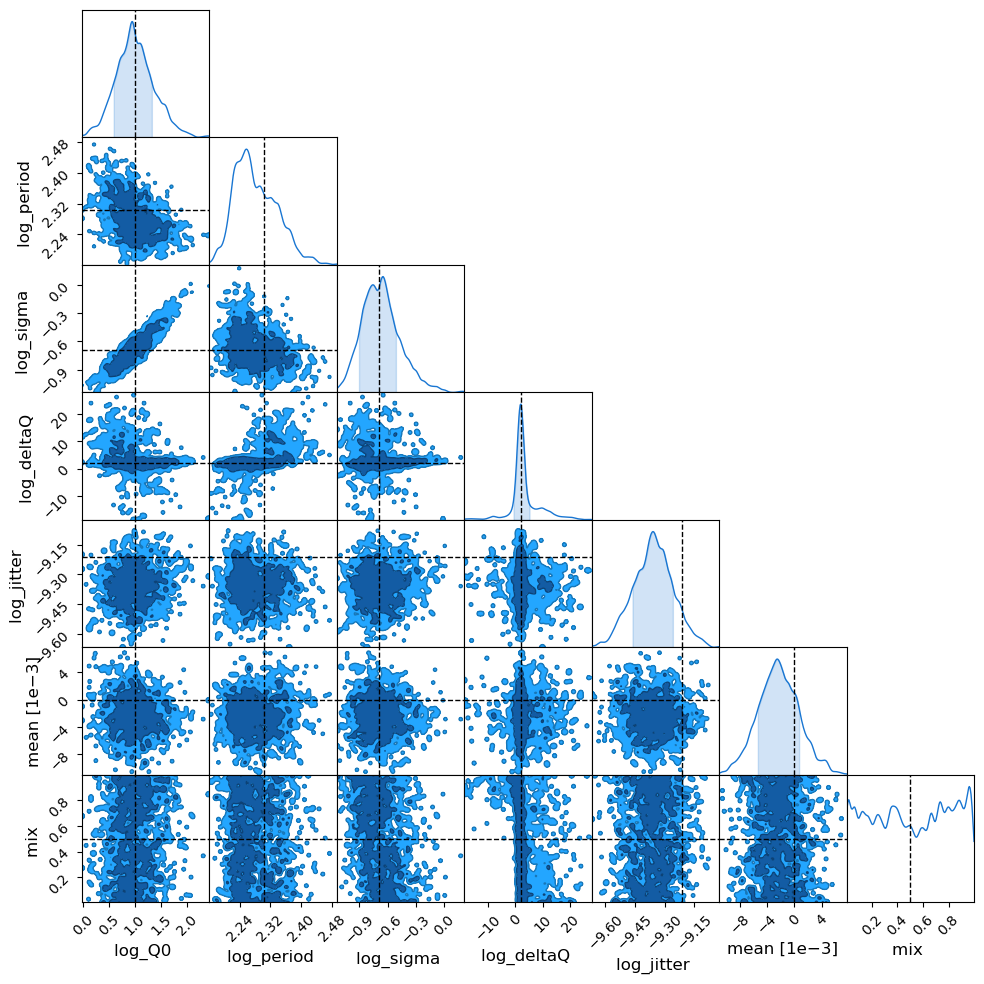

In [58]:
c= ChainConsumer()
c.add_chain([samples[key] for key in ['log_Q0', 'log_period', 'log_sigma', 'log_deltaQ', 'log_jitter', 'mean', 'mix']], 
parameters=['log_Q0', 'log_period', 'log_sigma', 'log_deltaQ', 'log_jitter', 'mean', 'mix'], name = 'HMC only')
c.plotter.plot(truth=true_params)
plt.show()


Looks pretty good! I think this suggests the basic implementation has legs and we just need to worry about engineering. 

To do: 

- Can we initialize the HMC better with an optimization stage? `numpyro` is weirdly not good for this. 
    - Could be a project for **Hugh**. 
- We actually probbably don't need a full HMC - can we use variational inference instead?
- Test on hand-labelled data. 
    - I think **Sydney** had some of this? 
- Package this up and pull request to Ruth.